In [32]:
import numpy as np 
import tables
import matplotlib.pyplot as plt
import os
import pickle

In [43]:
f_dir = 'two_module_lowCoh_model'
rep = 0
lr = 0.02

n_time = 70
n_iter = 300
n_btwn = 20
stim_st_time = 45
target_st_time = 25

In [42]:
def relu(input):
    return input * (input>0)

with open(os.path.join(f_dir, 'init_weight_%d_lr%f.pth'%(rep, lr)), 'rb') as f:
    w_init = np.load(f,allow_pickle=True)
with open(os.path.join(f_dir, 'model_results_%d_lr%f.pkl'%(rep, lr)), 'rb') as f:
    model_results =  pickle.load(f)
train_output = tables.open_file(os.path.join(f_dir, 'train_output_lr%f_rep%d.h5'%(lr, rep)), mode = 'r')
table = train_output.root
w_init = w_init.item()

In [39]:
h = table['h_iter280'][:]
y = table['y_hist_iter280'][:]
stim_level = table['stim_level_iter280'][:]
neural_in = table['neural_in_iter280'][:]
stim_dir = table['stim_dir_iter280'][:]

In [24]:
def find_coh_idx(stim_level):
    H_idx = np.array(stim_level)==b'H'
    M_idx = np.array(stim_level)==b'M'
    L_idx = np.array(stim_level)==b'L'
    Z_idx = np.array(stim_level)==b'Z'
    return H_idx, M_idx, L_idx, Z_idx

def find_sac_idx(y):
    choice = np.argmax(y, 2)
    contra_idx = choice==0
    ipsi_idx = choice==1
    return contra_idx, ipsi_idx

def recover_targ_loc(desired_out, stim_dir):
    # return the target arrangement: green_contra = 0, red_contra = 1
    choice = np.argmax(desired_out, 2)
    target = choice==1 # contra = 0, ipsi = 1
    dir = stim_dir==315 # green = 0, red = 1
    return np.logical_xor(target, dir)

def get_choice_color(y, desired_out, stim_dir):
    # return choice color (green = 0, red = 1)
    choice = np.argmax(y, 2)
    targ_loc = recover_targ_loc(desired_out, stim_dir)
    return np.logical_xor(choice, targ_loc)

def find_pref_dir(stim_dir, h):
    red_idx = stim_dir==315
    green_idx = stim_dir==135
    red_mean = np.mean(h[stim_st_time:, red_idx, :], axis=[0, 1])
    green_mean = np.mean(h[stim_st_time:, green_idx, :], axis=[0, 1])
    pref_red = red_mean>green_mean
    return pref_red

def calc_avg_idx(h, trial_idx, cell_idx):
    return np.mean(h[:, trial_idx, cell_idx], axis=[1, 2])

def plot_coh_avgAct(h, stim_level, stim_dir, cell_idx, save_plt):
    H_idx, M_idx, L_idx, Z_idx = find_coh_idx(stim_level)
    red_idx = stim_dir==315
    green_idx = stim_dir==135
    


    plt.plot(np.mean(h[:, np.logical_and(L_idx, green_idx), cell_idx], axis=1), color='#046C41', label='135, L')
    plt.plot(np.mean(h[:, np.logical_and(M_idx, green_idx), cell_idx], axis=1), color='#1AA33C', label='135, M')
    plt.plot(np.mean(h[:, np.logical_and(H_idx, green_idx), cell_idx], axis=1), color='#83D475', label='135, H')

    plt.plot(np.mean(h[:, np.logical_and(L_idx, red_idx), cell_idx], axis=1), color='#910000', label='315, L')
    plt.plot(np.mean(h[:, np.logical_and(M_idx, red_idx), cell_idx], axis=1), color='#D32431', label='315, M')
    plt.plot(np.mean(h[:, np.logical_and(H_idx, red_idx), cell_idx], axis=1), color='#CE5757', label='315, H')
    



    

In [41]:
h.shape

(70, 1024, 200)

In [49]:
np.logical_and(np.array(stim_level)==b'H', stim_dir==315)

array([False, False,  True, ..., False, False, False])

In [46]:
stim_dir==315

array([ True, False,  True, ...,  True, False,  True])

In [6]:
model_results.keys()

dict_keys(['total_accuracy', 'rt', 'loss', 'perf_loss', 'spike_loss', 'weight_loss', 'iteration', 'H_acc', 'M_acc', 'L_acc', 'Z_acc'])

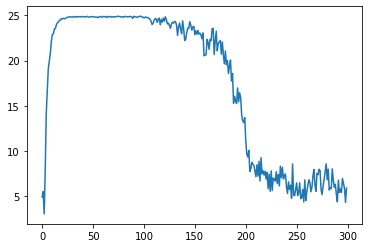

In [11]:
plt.plot(model_results['rt'])

In [ ]:
train_output.close()